<a href="https://colab.research.google.com/github/brinpat/machine-learning/blob/main/Stock_Market_Regression_and_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=94ba8772089a38545589518824d89c86aca2cfc570febc7616b8dbcae9be58c6
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


Train size: 50
Test size: 100
Stock name: goog
Start date (dd/mm/yyyy): 01/01/2021
(Train) Gradient Coefficient: 5.603 
(Train) Mean squared error: 5163.96 
(Train) Coefficient of determination: 0.732000

(Test) Gradient Coefficient: 5.603 
(Test) Mean squared error: 29194.88 
(Test) Coefficient of determination: 0.265000


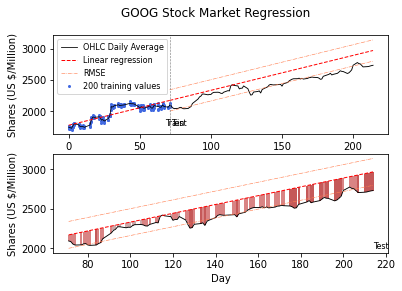

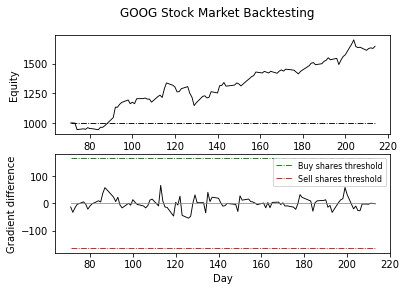

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import yahoofinancials as yf
from datetime import date

def df(stock_name,day,month,year):
    # Creates stock database
    stock = yf.YahooFinancials(str(stock_name))
    data=stock.get_historical_price_data(start_date=str(year)+'-'+str(month)+'-'+str(day),
                                         end_date=str(date.today()),time_interval='daily')
    db = pd.DataFrame(data[str(stock_name)]['prices']).drop('date', axis=1)
    db['formatted_date'] = pd.to_datetime(db['formatted_date'])
    db['Days'] = (db['formatted_date'] - db['formatted_date'][0]).dt.days
    db = db.set_index('formatted_date')
    return db, stock_name

def grad(x0,x1,y0,y1):
    # Determines the gradient between two points
    grd=(y1-y0)/(x1-x0)
    return grd

# Inputs
train_size=int(input('Train size: ')) # typical value: 10 sets
test_size=int(input('Test size: ')) # typical value: 10 sets
stockname=(input('Stock name: ')).upper() # Example stocks: MSFT, GOOG, TSLA, AADR
start_date=input('Start date (dd/mm/yyyy): ') # start date of database

# stock name and start date (Day, Month, Year)
database,stk=df(stockname,start_date[0:2],start_date[3:5],start_date[6:10])

# Features: Days, Formatted date
# Targets: open, high, low, close, volume, adjclose
datatype=['open','high','low','close']

# Split into train and test data sets
train=database[:train_size]
test=database[train_size-1:train_size+test_size]

X_train = train[['Days']]
X_test = test[['Days']]
Y_train = train[datatype]
Y_test = test[datatype]

# Regression Model
linear_regressor = linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # perform linear regression
Y_reg_train = linear_regressor.predict(X_train) # actual linear regression values
Y_reg_test = linear_regressor.predict(X_test)  # linear regression predictions

# Figure 1
fig,axs=plt.subplots(2)
fig.suptitle(str(stk)+' Stock Market Regression')

train_pts=str(len(datatype)*(len(X_train)))+' training values'

for i in range(0,len(datatype)-1):
    # train scatter plot
    axs[0].scatter(X_train,Y_train[datatype[i]],color='royalblue',s=4)
axs[0].scatter(X_train,Y_train[datatype[len(datatype)-1]],color='royalblue',s=4,label=train_pts)

# Training errors
mse_train=mean_squared_error(Y_train, Y_reg_train)
print('(Train) Gradient Coefficient:', round(np.mean(linear_regressor.coef_),3),'\n(Train) Mean squared error: %.2f'
      % round(mse_train,3),'\n(Train) Coefficient of determination: %.6f'
      % round(r2_score(Y_train, Y_reg_train),3))

# Testing errors
mse_test=mean_squared_error(Y_test, Y_reg_test)
rmse_test=np.sqrt(mse_test) # Route mean squared error
print('\n(Test) Gradient Coefficient:', round(np.mean(linear_regressor.coef_),3),'\n(Test) Mean squared error: %.2f'
      % round(mse_test,3),'\n(Test) Coefficient of determination: %.6f'
      % round(r2_score(Y_test, Y_reg_test),3))

# Compute means of data
Y_train=Y_train.mean(axis=1)
Y_test=Y_test.mean(axis=1)
Y_reg_train=Y_reg_train.mean(axis=1)
Y_reg_test=Y_reg_test.mean(axis=1)

# Defining label for type of average
av_type=''
for i in range(0,len(datatype)):
    av_type+=(datatype[i][0].upper())

# Trained values Gradients
g=grad(X_train.values[range(0,len(X_train.values)-1)],X_train.values[range(1,len(X_train.values))],
       Y_train.values[range(0,len(X_train.values)-1)],Y_train.values[range(1,len(X_train.values))])

# Trained values Gradient vs Regression Gradient
grad_diff_train=g.mean(axis=0)-np.mean(linear_regressor.coef_)
grad_train_range=max(grad_diff_train)-min(grad_diff_train)

# Tested values Gradients
g=grad(X_test.values[range(0,len(X_test.values)-1)],X_test.values[range(1,len(X_test.values))],
       Y_test.values[range(0,len(X_test.values)-1)],Y_test.values[range(1,len(X_test.values))])
grad_diff_test=g.mean(axis=0)-np.mean(linear_regressor.coef_) # Tested values Gradient vs Regression Gradient

shares=0 # initial shares
equity=[1000]*(len(grad_diff_test)+1) # equity

# Indicator positions in x and y
xind=X_test[0:len(grad_diff_test)].values
yind=np.mean(linear_regressor.coef_)*xind+Y_reg_train[0]
sc=25*100/np.mean(Y_test) # Scale constant
gradlim=grad_train_range # threshold limit for buy and sell

close_diff=test['adjclose']-test['adjclose'][0]

# Indicators and backtesting
# Acquired backtesting ideas from https://www.datacamp.com/community/tutorials/finance-python-trading

for i in range(0,len(grad_diff_test)):
    if grad_diff_test[i] > gradlim:
        axs[1].scatter(xind[i], yind[i], color='g', marker='^', s=grad_diff_test[i]*sc) # buy indicator
        shares=10*grad_diff_test[i]  # Buy shares

    elif grad_diff_test[i] < -gradlim:
        axs[1].scatter(xind[i], yind[i], color='r', marker='v', s=-grad_diff_test[i]*sc) # sell indicator
        shares=10*grad_diff_test[i]  # Sell shares

    equity[i+1]+=close_diff[i]+shares # equity back testing via trading

# Colour errors by upper and lower quartiles
vert_offset=(Y_test-Y_reg_test) # Regression residuals
col=[]
for i in range(0,len(vert_offset)):
    if vert_offset.values[i] > max(vert_offset.values*0.75):
        col.append('darkgreen')

    elif vert_offset.values[i] > max(vert_offset.values*0.25):
        col.append('green')

    elif vert_offset.values[i] > 0:
        col.append('lightgreen')

    elif vert_offset.values[i] < min(vert_offset.values*0.75):
        col.append('firebrick')

    elif vert_offset.values[i] < min(vert_offset.values*0.25):
        col.append('indianred')
    else:
        col.append('rosybrown')

# Create gradient limit lines (Threshold)
val=gradlim
y=np.linspace(val,val,len(grad_diff_test))

## Train and test plot
axs[0].plot(X_train,Y_train, color='black', linewidth=0.8,label=av_type+' Daily Average') # train plot
axs[0].plot(X_test,Y_test, color='black', linewidth=0.9) # test plot
axs[0].plot(X_train, Y_reg_train, color='red',linestyle='dashed', linewidth=1) # train regression line
axs[0].plot(X_test, Y_reg_test, color='red',linestyle='dashed', linewidth=1,
            label='Linear regression') # test regression line
axs[0].plot(X_test, Y_reg_test+rmse_test, color='coral', linestyle='-.', linewidth=0.6,label='RMSE') # +RMSE
axs[0].plot(X_test, Y_reg_test-rmse_test, color='coral', linestyle='-.', linewidth=0.6) # -RMSE

# Split plot by train and test
axs[0].axvline(max(X_train.values),color='grey',linewidth=0.6,linestyle='dashed')

axs[0].set(ylabel='Shares (US $/Million)')
axs[0].legend(prop={'size':8})
axs[0].text(max(X_train.values-3),min(Y_reg_train),'Train',fontsize=8)
axs[0].text(min(X_test.values+1),min(Y_reg_train),'Test',fontsize=8)

# Plot test and errors
axs[1].vlines(X_test,ymin=Y_test,ymax=Y_reg_test,colors=col,linestyles='solid')
axs[1].plot(X_test,Y_test, color='black', linewidth=0.9) # test plot
axs[1].plot(X_test,Y_reg_test, color='red', linestyle='dashed', linewidth=1) # test regression line
axs[1].plot(X_test, Y_reg_test+rmse_test, color='coral', linestyle='-.', linewidth=0.6) # +RMSE
axs[1].plot(X_test, Y_reg_test-rmse_test, color='coral', linestyle='-.', linewidth=0.6) # -RMSE
plt.xlabel('Day')
plt.ylabel('Shares (US $/Million)')
axs[1].text(max(X_test.values-0.2),min(Y_reg_test-rmse_test),'Test',fontsize=8)
plt.show()

# Figure 2
fig,axs=plt.subplots(2)
fig.suptitle(str(stk)+' Stock Market Backtesting')

# Equity backtesting plot
axs[0].plot(X_test,equity, color='black', linestyle='-', linewidth=0.9)
axs[0].plot(X_test,np.linspace(equity[0],equity[0],len(X_test)), color='black', linewidth=0.9,linestyle='-.')
axs[0].set(ylabel='Equity')

# Gradient difference plot
axs[1].plot(X_test.values[0:test_size],grad_diff_test, color='black', linewidth=0.9)
axs[1].plot(X_test.values[0:test_size],y, color='green', linewidth=0.9,linestyle='-.',
            label='Buy shares threshold')
axs[1].plot(X_test.values[0:test_size],-y, color='red', linewidth=0.9,linestyle='-.',
            label='Sell shares threshold')
axs[1].plot(X_test.values[0:test_size],[0]*test_size, color='grey', linewidth=0.7,linestyle='-')
plt.xlabel('Day')
plt.ylabel('Gradient difference')
plt.legend(fontsize=8)
plt.show()
